# Tabular Data Science Walkthrough

## Summary Instructions

We’re experimenting with a feature to curate a set of meals to send to a user via email each day so they can order with one click. We will send 5 new meal options to a user and hope that one of them is what they want for lunch that day. We would like to understand how many orders we should expect for each meal tomorrow.

The data you should use to help you explore this question is in the following csv files:

* user_features - features describing our users
* meal_features - features describing the meals our restaurant partners serve
* meals_previously_seen - contains which meals users had previously seen and whether that user ordered the meal
* meals_to_be_sent - data on which meals will be sent to users tomorrow

## Running The Notebook

This notebook runs on Python 3. Most of the libraries used come pre-installed with Anaconda, but the dataframe summarizer pandas_summary and the machine learning library fastai do not. They can be installed using from the terminal with Anaconda builds by using:

`pip install pandas_summary
pip install fastai`

You can also install these from the notebook with:

`!pip install pandas_summary
!pip install fastai`

Any other missing libraries can be fixed with a similar 'pip' install. If an error arises, try updating, restarting the kernel, and re-running the notebook.

## Investigating The Problem

According to the instructions, the goal is to "understand how many orders we should expect for each meal tomorrow" and the final output "should be a table containing the meals and the number of orders we should expect."

We will "do data science" by way of investigating the problem and performing exploratory data analysis, data cleaning, feature engineering, machine learning, neural networks, interpretation, and more.

Let's dive in!

In [1]:
# File imports
from IPython.display import display
import numpy as np
np.random.seed(33)
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_summary import DataFrameSummary as dfs

Let's take a look at the .csv files. I'll use the pandas_summary library to look at the column stats.

In [2]:
meal_features = pd.read_csv('meal_features.csv')
meals_seen = pd.read_csv('meals_previously_seen.csv')
meals_sent = pd.read_csv('meals_to_be_sent.csv')
user_features = pd.read_csv('user_features.csv')

views = [0, 1, 2, -3, -2, -1]

print("User features:")
display(user_features.iloc[views], dfs(user_features).columns_stats)

print("\nMeal Features:") 
display(meal_features.iloc[views], dfs(meal_features).columns_stats)

print("\nMeals previously seen:")
display(meals_seen.iloc[views], dfs(meals_seen).columns_stats)

print("\nMeals previously seen sorted:")
meals_seen = meals_seen.sort_values(by=['user_id'])
display(meals_seen.head(11))

print("\nMeals to be sent:")
display(meals_sent.iloc[views], dfs(meals_sent).columns_stats)

print("\nMeals to be sent sorted:")
meals_sent = meals_sent.sort_values(by=['user_id'])
display(meals_sent.head(11))

User features:


,user_id,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines
0,104939,2,True,"['korean', 'italian', 'chinese', 'vegetarian',..."
1,101562,2,True,"['mediterranean', 'indian', 'thai', 'american'..."
2,102343,2,True,"['thai', 'italian', 'japanese', 'chinese']"
11997,106873,2,False,"['middle-eastern', 'thai', 'mediterranean', 'v..."
11998,107769,NaN,True,"['vegetarian', 'mediterranean', 'thai', 'itali..."
11999,103190,0,True,"['indian', 'italian', 'mediterranean', 'vegeta..."


,user_id,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines
counts,12000,11500,12000,12000
uniques,12000,7,2,8316
missing,0,500,0,0
missing_perc,0%,4.17%,0%,0%
types,numeric,categorical,bool,categorical



Meal Features:


,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score
0,1134,thai,False,101,3.349452
1,1846,american,False,111,5.000000
2,1762,latin,False,220,4.882706
997,1062,japanese,True,705,3.602008
998,1721,italian,True,306,1.846254
999,1995,mediterranean,True,199,3.576706


,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score
counts,1000,1000,1000,1000,1000
uniques,1000,11,2,602,828
missing,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%
types,numeric,categorical,bool,numeric,numeric



Meals previously seen:


,user_id,meal_id,ordered
0,104863,1350,False
1,108656,1321,True
2,100120,1110,False
35987,105921,1018,False
35988,106064,1082,True
35989,100664,1063,True


,user_id,meal_id,ordered
counts,35990,35990,35990
uniques,7200,1000,2
missing,0,0,0
missing_perc,0%,0%,0%
types,numeric,numeric,bool



Meals previously seen sorted:


,user_id,meal_id,ordered
35518,100001,1363,True
11518,100001,1893,False
24915,100001,1738,False
34360,100001,1402,True
35155,100001,1129,False
639,100002,1235,False
32596,100002,1755,False
11641,100002,1917,True
6084,100002,1393,False
20836,100002,1170,False



Meals to be sent:


,user_id,meal_id
0,108618,1663
1,110536,1254
2,104197,1798
56387,109167,1338
56388,102433,1979
56389,111917,1563


,user_id,meal_id
counts,56390,56390
uniques,11280,1000
missing,0,0
missing_perc,0%,0%
types,numeric,numeric



Meals to be sent sorted:


,user_id,meal_id
25186,100000,1361
2277,100000,1646
40996,100000,1857
46298,100000,1657
55526,100000,1486
13735,100001,1094
8302,100001,1002
53972,100001,1315
29073,100001,1521
35166,100001,1049


The 'meals to be sent' file is what can be used to create the output. It presents sets of five meal ids attached to a single user id, but is unlabeled. So we can try to predict which of the five meals a user will order, if any.

How can we do this? By looking at what users had ordered in the past. There are two columns for this, ordered_yesterday, which is attached to the 'user feature' file, and the 'meals previously seen' file, which also presents sets of five meal ids attached to a single user id, but this time it displays whether a meal has been ordered or not. It shows that a user may have ordered multiple meals. But when? 

1. If yesterday, then there should be consistency between a user's orders and the 'ordered_yesterday' column in the 'user features' file by joining on users.
2. If another day, then there must be inconsistency on the above. However, this option seems unlikely.
3. If it is over the duration of the subscription, then there will be also inconsistency. This seems far more likely than 2).

Let's see if we can use the data to figure this out. We'll begin by operating under the assumption that 3) is correct.

In [3]:
# For the test df, merge our meals sent dataframe with meal features and user features, keeping the structure
test_df = pd.merge(meals_sent, meal_features, on='meal_id', how='left').merge(user_features, on='user_id', how='left')
print('To predict:'), display(test_df.iloc[views], dfs(test_df).columns_stats)

# For the labeled df, start with user features, which has 'ordered yesterday'
labeled_df = pd.merge(user_features, meals_seen, on='user_id', how='left').merge(meal_features, on='meal_id', 
                                                                                 how='left')
labeled_df = labeled_df.dropna(subset=['meal_id'])
print('\nLabeled data:'), display(labeled_df.iloc[views], dfs(labeled_df).columns_stats)

To predict:


,user_id,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines
0,100000,1361,korean,True,662,-1.000000,1,True,"['thai', 'korean']"
1,100000,1646,korean,True,242,4.357342,1,True,"['thai', 'korean']"
2,100000,1857,vegetarian,True,102,5.000000,1,True,"['thai', 'korean']"
56387,111999,1111,japanese,True,525,3.370569,0,False,"['chinese', 'mediterranean', 'japanese', 'kore..."
56388,111999,1750,vegetarian,True,98,1.159617,0,False,"['chinese', 'mediterranean', 'japanese', 'kore..."
56389,111999,1355,japanese,True,650,0.704539,0,False,"['chinese', 'mediterranean', 'japanese', 'kore..."


,user_id,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines
counts,56390,56390,56390,56390,56390,56390,54056,56390,56390
uniques,11280,1000,11,2,602,828,7,2,7848
missing,0,0,0,0,0,0,2334,0,0
missing_perc,0%,0%,0%,0%,0%,0%,4.14%,0%,0%
types,numeric,numeric,categorical,bool,numeric,numeric,categorical,bool,categorical



Labeled data:


,user_id,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines,meal_id,ordered,cuisine,large_portion,number_of_reviews,avg_review_score
0,104939,2,True,"['korean', 'italian', 'chinese', 'vegetarian',...",1212.0,False,middle-eastern,True,789.0,1.461363
1,104939,2,True,"['korean', 'italian', 'chinese', 'vegetarian',...",1195.0,True,vegetarian,True,358.0,1.018924
2,104939,2,True,"['korean', 'italian', 'chinese', 'vegetarian',...",1569.0,False,middle-eastern,True,107.0,-1.000000
35987,108228,6+,True,"['latin', 'japanese', 'thai', 'vegetarian', 'i...",1085.0,False,italian,True,659.0,3.361859
35988,108228,6+,True,"['latin', 'japanese', 'thai', 'vegetarian', 'i...",1840.0,True,middle-eastern,True,628.0,2.191802
35989,108228,6+,True,"['latin', 'japanese', 'thai', 'vegetarian', 'i...",1777.0,True,middle-eastern,True,353.0,5.000000


,user_id,number_of_subscription_cycles,ordered_yesterday,favorite_cuisines,meal_id,ordered,cuisine,large_portion,number_of_reviews,avg_review_score
counts,35990,34425,35990,35990,35990,35990,35990,35990,35990,35990
uniques,7200,7,2,5174,1000,2,11,2,602,828
missing,0,1565,0,0,0,0,0,0,0,0
missing_perc,0%,4.35%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,categorical,bool,categorical,numeric,bool,categorical,bool,numeric,numeric


(None, None)

In [4]:
print("Number of users who have positive order history but did not order yesterday:", 
      len(labeled_df.loc[(labeled_df['ordered'] == True) & (labeled_df['ordered_yesterday'] == False)]))

ordered_yesterday_sz = labeled_df.loc[labeled_df['ordered_yesterday'] == True].groupby(['user_id', 'ordered']).size()
ordered_yesterday_sz = ordered_yesterday_sz.reset_index()
no_order_history = ordered_yesterday_sz.loc[ordered_yesterday_sz['ordered'] == False]
print("Number of users who have no order history but ordered yesterday:", 
      len(no_order_history.loc[no_order_history[0] == 5]))

Number of users who have positive order history but did not order yesterday: 2722
Number of users who have no order history but ordered yesterday: 439


The tests in the cell above confirms that the meal ordered and ordered_yesterday columns are not linked at all. 

Continuing to operate under the assumption in option 3), this confirms that there isn't enough information to determine:

* Exactly which meals were ordered yesterday
* (and therefore) which users ordered what meal yesterday
* When meals were ordered by users
* How often a meal was ordered (except yesterday and in the case of 0s) by a user

We do know:

* Which users ordered a meal yesterday
* Which meals were not ordered by users yesterday if no meal was ordered
* Which users ordered what meal sometime within (presumably) the subscription duration

So in service of using past orders to predict future orders, we can make educated guesses as to:

* Which meals may have been ordered yesterday
* Which meals may have been ordered on specific dates in the past

Let's focus on which meals may have been ordered yesterday, as can use this as the basis for the target column in a model and it relies on fewer assumptions.

## Engineering a Target

We'll start by looking at the thing most closely resembling a target, the 'ordered_yesterday' columns.

"True" count      8400
"True" perc        70%
"False" count     3600
"False" perc       30%
counts           12000
uniques              2
missing              0
missing_perc        0%
types             bool
Name: ordered_yesterday, dtype: object

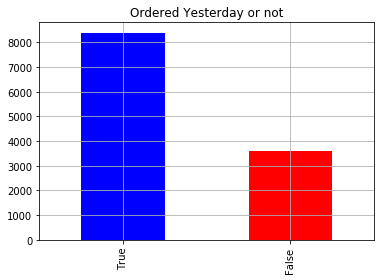

In [5]:
user_features['ordered_yesterday'].value_counts().plot.bar(title="Ordered Yesterday or not", color=['blue', 'red'], 
                                                           grid=True)
dfs(user_features)['ordered_yesterday']

70% of users ordered a meal yesterday. Since according to the instructions, "we will send 5 new meal options to a user and hope that one of them is what they want for lunch that day", we'll assume that a user can only pick one meal. That's a one-in-five chance, and 1/5th of 70 is 14. So with this information, we should expect about 14% chance that a given meal will be ordered and an 86% chance that a meal will not be ordered.

In [6]:
print("Percent of meals previously seen:", np.round(len(pd.merge(meals_sent, meals_seen, 
                                                        on=['user_id', 'meal_id']))*100/len(meals_seen), 2), '%')

Percent of meals previously seen: 0.56 %


It looks like the vast majority of most of the meals sent will be unseen by users.

We don't know exactly what meals were ordered yesterday, but we can look at the data and make an educated guess if we know the following: *If a meal had been ordered in the past, what is the estimated likelihood they would choose it again over another option?*

In [7]:
# Filter by meals with true order 
ordered_true = labeled_df.loc[labeled_df['ordered'] == True]
# Get number of different orders
ordered_true['order_count'] = ordered_true.groupby('user_id')['ordered'].transform(lambda x: x.count())
# Count the number of different meals ordered by users, and subtract one since we're looking for new choices
ordered_true['unique_order_count'] = ordered_true.groupby('user_id')['ordered'].transform(lambda x: x.count() - 1)
# Filter users with at least one new choice
ordered_true = ordered_true.loc[ordered_true['unique_order_count'] >= 1]

# Next let's try to find the number of days a user had to make a unique order.
print("Set of number of subsription cycles", set(labeled_df['number_of_subscription_cycles']))
# There's a 6+ and nan in number of subscription cycles. Let's play it safe and only include 1-5.
ordered_true = ordered_true.loc[ordered_true['number_of_subscription_cycles'].isin(['1', '2', '3', '4', '5'])]
# We've been instructed that the number of days should be 16.
num_days = 16

# Find avg of unique orders divided by 70% (the % of users who ordered yesterday) of the number of days to choose from
chance_of_new_order = np.mean(ordered_true['unique_order_count']/(num_days*0.7))
print("Chance of a new, unique order if there is an order history", np.round(chance_of_new_order, 3))

/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Set of number of subsription cycles {nan, '2', '6+', '4', '3', '1', '5', '0'}
Chance of a new, unique order if there is an order history 0.158


/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Next we'll estimate if the people who ordered yesterday ordered the something they had previously ordered or 
something new by shuffling the data, filtering by those who ordered yesterday. If they had, then there is about a 8% chance they ordered something new, per the estimate above. We'll randomly select from the new orders and previous orders, as there is not a lot of information to go on.

"False" count     31303
"False" perc     86.98%
"True" count       4687
"True" perc      13.02%
counts            35990
uniques               2
missing               0
missing_perc         0%
types              bool
Name: meal_ordered_yesterday, dtype: object

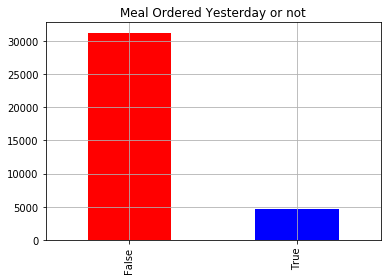

In [8]:
from random import sample 
  
# Shuffle the data and filter by those who ordered yesterday, select the first instance per user
labeled_df = labeled_df.sample(frac=1).reset_index(drop=True)
labeled_true = labeled_df.loc[labeled_df['ordered_yesterday'] == True]
df_ordered_first = labeled_true.drop_duplicates(subset=['user_id', 'ordered'], keep='first')

# Grab indices of true and false indices from yesterday
df_ordered_first_indices = list(df_ordered_first.loc[(df_ordered_first['ordered'] == True)].index)
df_not_ordered_first_indices = list(df_ordered_first.loc[(df_ordered_first['ordered'] == False)].index)

# Sample randomly using the chance of a new order
df_ordered_first_indices = sample(df_ordered_first_indices, int((1-chance_of_new_order)*len(df_ordered_first_indices))) 
df_not_ordered_first_indices = sample(df_not_ordered_first_indices, 
                                      int(chance_of_new_order*len(df_not_ordered_first_indices))) 
df_ordered_yesterday_indices = df_ordered_first_indices + df_not_ordered_first_indices

# Apply to the labeled dataframe
labeled_df['meal_ordered_yesterday'] = False
for ind in df_ordered_yesterday_indices:
    labeled_df.at[ind, 'meal_ordered_yesterday'] = True
cols = list(labeled_df)
cols.insert(0, cols.pop(cols.index('meal_ordered_yesterday')))
labeled_df = labeled_df.loc[:, cols]
labeled_df = labeled_df.sort_values(by='user_id').reset_index(drop=True)

labeled_df['meal_ordered_yesterday'].value_counts().plot.bar(title="Meal Ordered Yesterday or not", 
                                                             color=['red', 'blue'], grid=True)
dfs(labeled_df)['meal_ordered_yesterday']

It's a little hand-wavy, but this data has that 13% of meals were ordered yesterday, which is close to the theoretical value of 14%. Now we have a target!

## Exploratory Data Analysis, Feature Engineering

With the target finally engineered, we can on analyzing features and creating others. I chose to immediately turn number of subscription cycles to a floating point number, count the number of favorite cuisines for a user, and determine if the cuisine of the meal was in the user's 'favorite_cuisines'.

In [9]:
def engineer_columns(df):
    df = df.drop('ordered_yesterday', 1)
    df['num_subscription_cycles_float'] = df['number_of_subscription_cycles']
    df['num_subscription_cycles_float'] = df['num_subscription_cycles_float'].str.replace('+', '')
    df['num_subscription_cycles_float'] = pd.to_numeric(df['num_subscription_cycles_float'])
    df['num_favorite_cuisines'] = [x.count(',') + 1 for x in df['favorite_cuisines'].astype(str)]
    df['cuisine_favorite'] = [x in y for x, y in zip(df['cuisine'], df['favorite_cuisines'])]
    return df

# These should be done to both sets
labeled_df = engineer_columns(labeled_df)
test_df = engineer_columns(test_df)

Since users will almost certainly see unseen meals on the test set, we can't use whether the user has ordered a meal as a feature on the labeled set.

However, we can see if a cuisine of a meal had been ordered previously and how many unique meals this corresponded to. This seems like it could be an important feature.

In [10]:
# Count the amount of unique meals previously ordered by cuisine
df_temp = labeled_df.loc[labeled_df['ordered'] == True].drop('ordered', 1)
df_temp = df_temp.groupby(['user_id', 'cuisine']).size().reset_index().rename(columns={0:'cuisine_ordered'})

# Merge on labeled and test set
def create_cuisines_ordered(df):
    df = pd.merge(df, df_temp, on=['user_id', 'cuisine'], how='left')
    df['cuisine_ordered'] = df['cuisine_ordered'].fillna(0)
    return df

# Apply to both sets
labeled_df = create_cuisines_ordered(labeled_df)
test_df = create_cuisines_ordered(test_df)

Labeled:


/Users/matthewignal/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


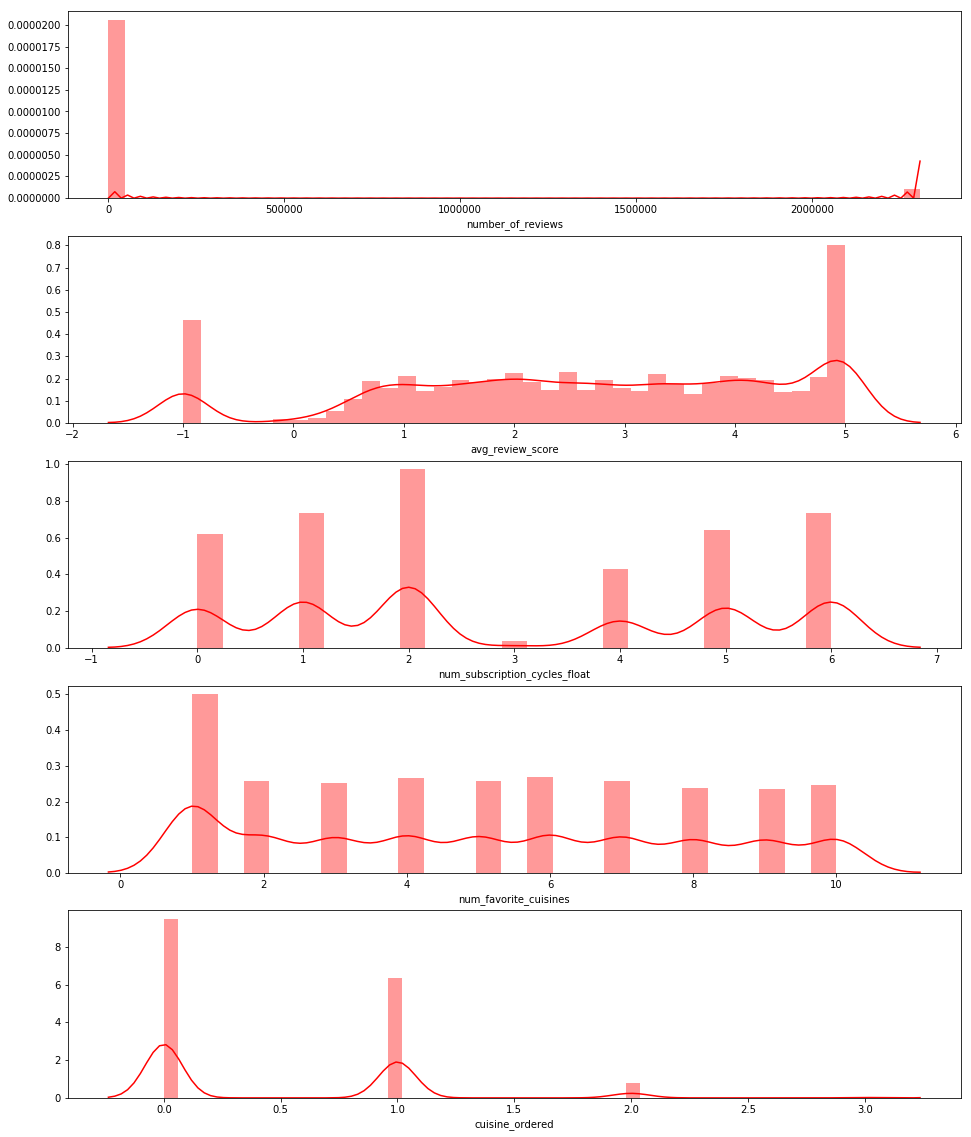

Test:


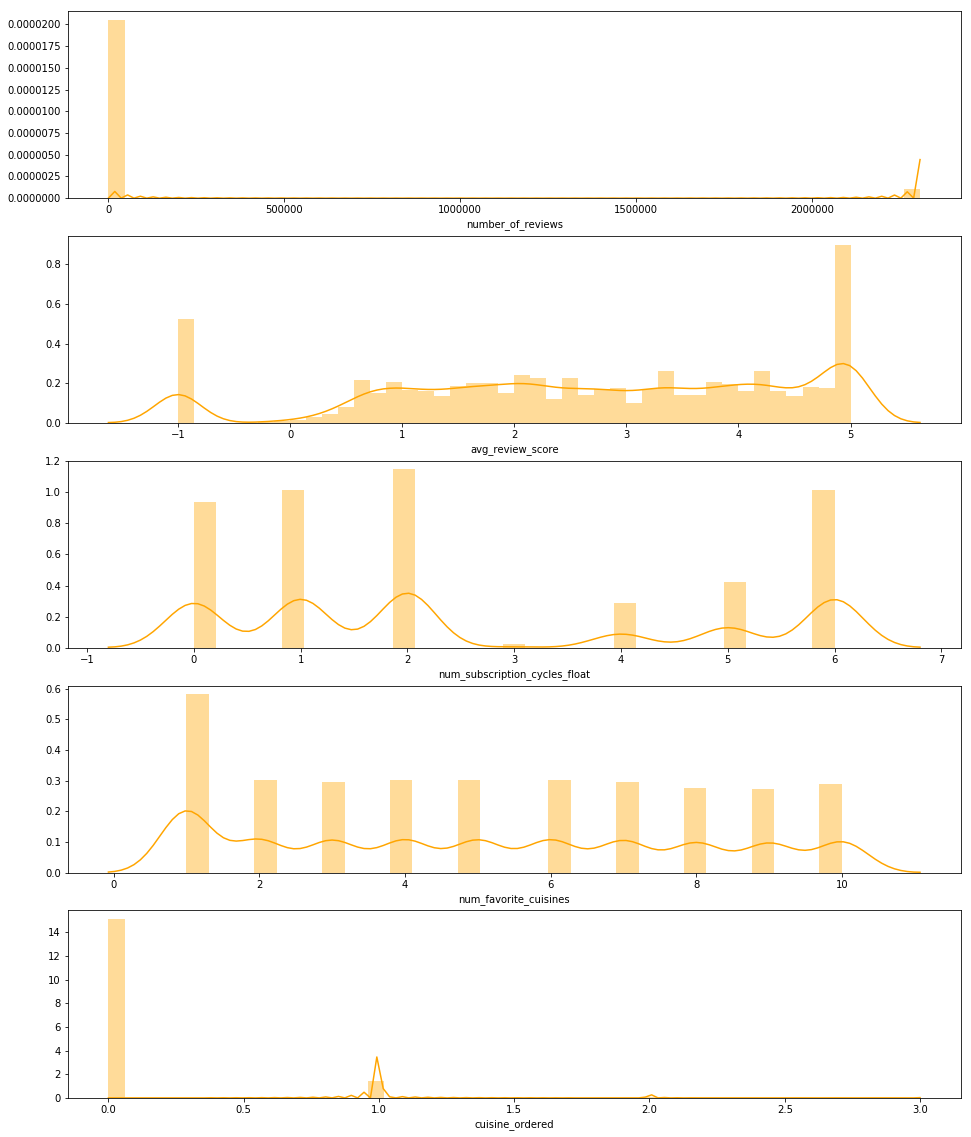

(None, None)

In [11]:
numeric_cols = ['number_of_reviews', 'avg_review_score', 'num_subscription_cycles_float', 
                'num_favorite_cuisines', 'cuisine_ordered']

def plot_dist(df, numeric_cols, color):
    '''
    Plots distribution of values to detect outliers, nonsensical values'''
    fig, ax = plt.subplots((len(numeric_cols)), figsize=(16,len(numeric_cols)*4))
    for i, col_val in enumerate(numeric_cols):
        sns.distplot(df[col_val].dropna(), hist=True, ax=ax[i], color=color)
    plt.show()
    
print("Labeled:"), plot_dist(labeled_df, numeric_cols, color='r')
print("Test:"), plot_dist(test_df, numeric_cols, color='orange')

There's a massive outlier in number of reviews that doesn't make sense. There are also review scores of -1. We will replace these with NaN values for now. The number of subscription cycles is extremely low at 3. Could the subscription cycles NaNs belong here? I'm not sure, so I'll treat the NaN as a category in one instance, and fill them in for 3 in another, which is also the middle value -- a safe choice.

/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


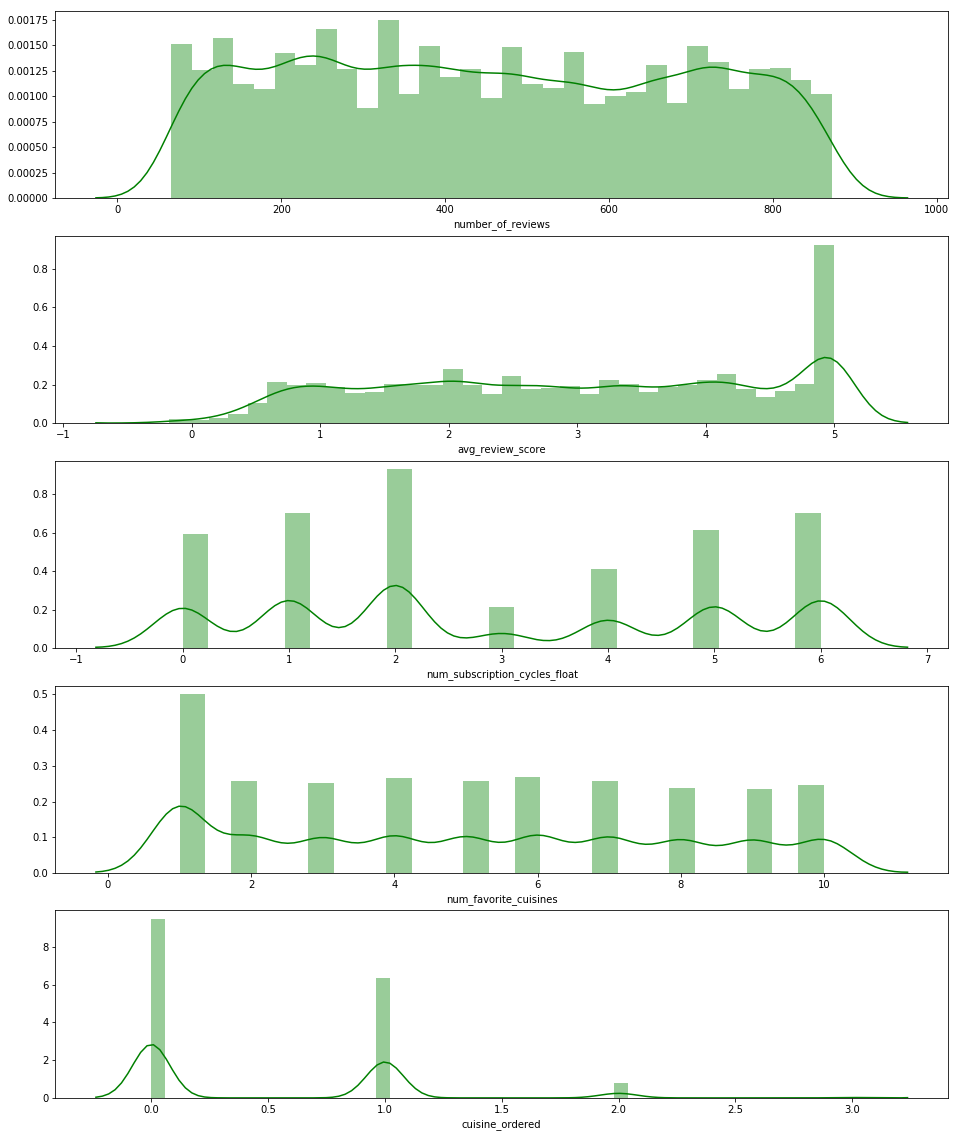

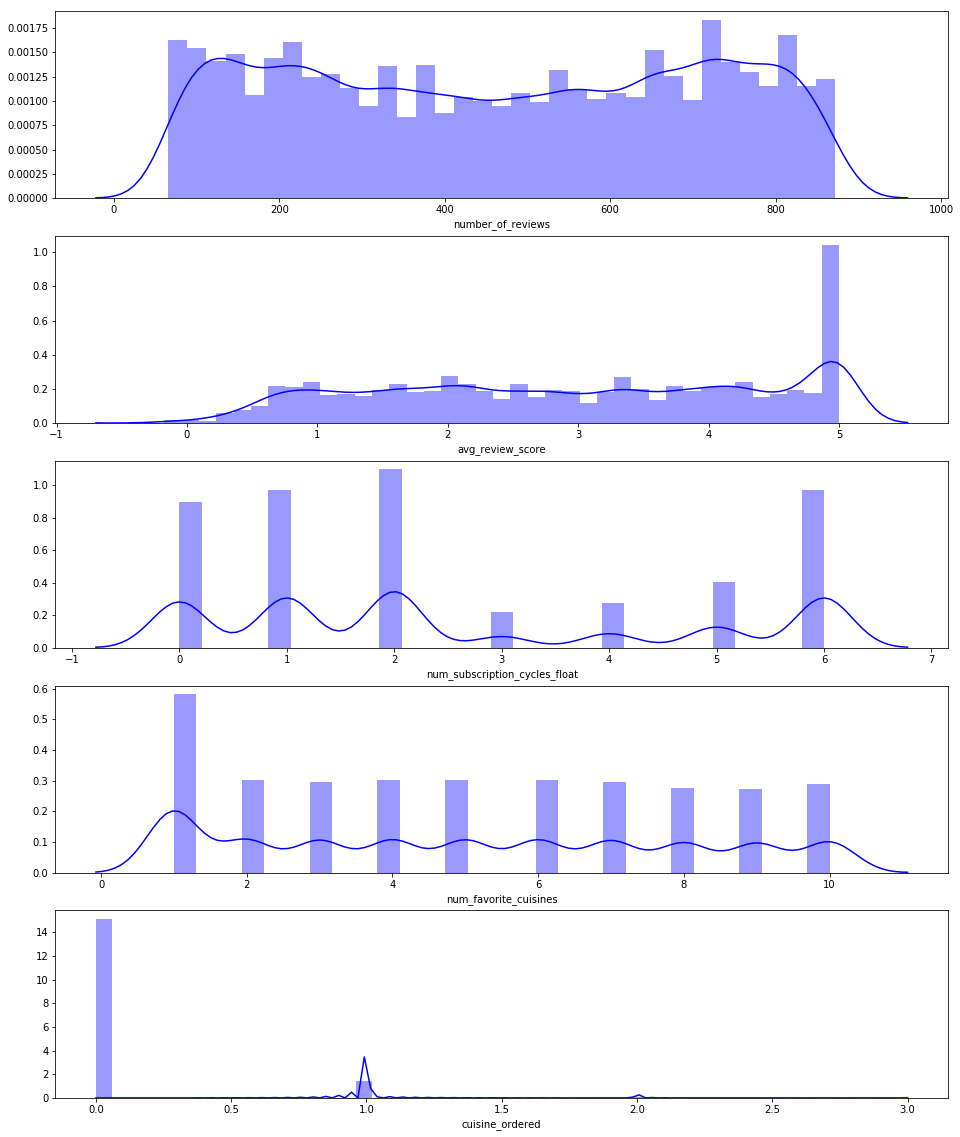

In [12]:
def make_adjustments(df):
    df['avg_review_score'] = df['avg_review_score'].replace(-1, np.nan)
    df['number_of_reviews'][df['number_of_reviews'] >= 1e5] = np.nan
    df['num_subscription_cycles_float'] = df['num_subscription_cycles_float'].replace(np.nan, 3)
    return df

# These should be done to both sets
labeled_df = make_adjustments(labeled_df)
test_df = make_adjustments(test_df)

plot_dist(labeled_df, numeric_cols, color='g')
plot_dist(test_df, numeric_cols, color='b')

The changes look good.

Next we'll make dummy variables by one-hot encoding the cuisine category and making 6 subscription cycles plus and NaNs their own category as their meaning is ambiguous.

In [13]:
cats = ['cuisine']
def make_dummies(df):
    dummy_df = pd.get_dummies(df[cats])
    df = pd.concat([df, dummy_df], axis=1)
    df['6_cycles_plus'] = np.nan
    df['6_cycles_plus'][df['number_of_subscription_cycles'] == '6+'] = 1
    df['6_cycles_plus'] = df['6_cycles_plus'].fillna(0)
    df['unk_cycles'] = np.nan
    df['unk_cycles'][df['number_of_subscription_cycles'].isnull()] = 1
    df['unk_cycles'] = df['unk_cycles'].fillna(0)
    return df

# Apply to both sets
labeled_df = make_dummies(labeled_df)
test_df = make_dummies(test_df)

/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's take another look at our data and make a correlation heatmap to quickly examine relationships

Labeled:


,meal_ordered_yesterday,user_id,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score,num_subscription_cycles_float,num_favorite_cuisines,cuisine_favorite,cuisine_ordered,cuisine_american,cuisine_chinese,cuisine_indian,cuisine_italian,cuisine_japanese,cuisine_korean,cuisine_latin,cuisine_mediterranean,cuisine_middle-eastern,cuisine_thai,cuisine_vegetarian,6_cycles_plus,unk_cycles
counts,35990,35990,35990,35990,35990,34220,33281,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990,35990
uniques,2,7200,1000,11,2,557,827,7,10,2,4,2,2,2,2,2,2,2,2,2,2,2,2,2
missing,0,0,0,0,0,1770,2709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,4.92%,7.53%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,bool,numeric,numeric,categorical,bool,numeric,numeric,numeric,numeric,bool,numeric,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool



Test:


,user_id,meal_id,cuisine,large_portion,number_of_reviews,avg_review_score,num_subscription_cycles_float,num_favorite_cuisines,cuisine_favorite,cuisine_ordered,cuisine_american,cuisine_chinese,cuisine_indian,cuisine_italian,cuisine_japanese,cuisine_korean,cuisine_latin,cuisine_mediterranean,cuisine_middle-eastern,cuisine_thai,cuisine_vegetarian,6_cycles_plus,unk_cycles
counts,56390,56390,56390,56390,53501,52175,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390,56390
uniques,11280,1000,11,2,557,827,7,10,2,4,2,2,2,2,2,2,2,2,2,2,2,2,2
missing,0,0,0,0,2889,4215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,5.12%,7.47%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,numeric,categorical,bool,numeric,numeric,numeric,numeric,bool,numeric,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool


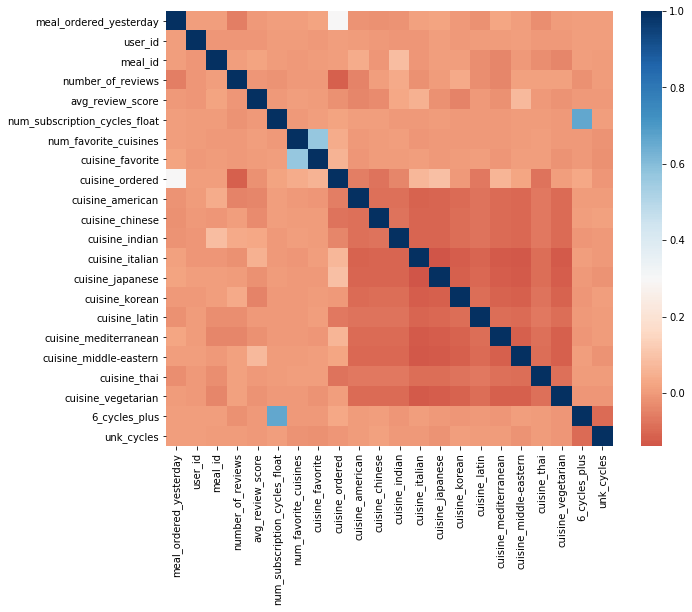

In [14]:
# Drop unwanted columns
labeled_df = labeled_df.drop(['number_of_subscription_cycles', 'favorite_cuisines', 'ordered'], 1)
test_df = test_df.drop(['number_of_subscription_cycles', 'favorite_cuisines'], 1)

print("Labeled:"), display(dfs(labeled_df).columns_stats)
print("\nTest:"), display(dfs(test_df).columns_stats)

# Correlation plot
fig, ax = plt.subplots(figsize=(10, 8))
corr = labeled_df.corr()
sns.heatmap(corr, center=0.3, cmap = "RdBu",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The good: There is the potential information gain with all of our features due to low feature correlations.

The bad: For our target column, only if the cuisine was seen previously shows much of a correlation (and it is pretty weak).

## Machine Learning

The point of this exercise is not to spend time perfecting a model, so there will be no hyperperameter tuning. By the same token, I will not be experimenting with feature selection since I have no expectation as to whether it will help or not. (I tend to do tree-based feature importance scores--especially Shapley values--on cross-validation folds to avoid selection bias.)

To split up our dataset into training and validation folds, let's take one random example for each user and put it in the validation set while the rest go in training. (An 80/20 split on 36,000 counts seems appropriate.)

We'll then try out some Sci-Kit Learn model's and a Neural Network.

In [15]:
def select_one_from_user(df):
    '''
    Shuffles the data and selects the last user_id for validation set'''
    df = df.sample(frac=1).reset_index(drop=True)
    df_last = df.drop_duplicates(subset=['user_id'], keep='last')
    df = df.drop(list(df_last.index), 0)
    return df, df_last, df_last.index

# Perform on labeled data only
train, valid, valid_idx = select_one_from_user(labeled_df)

# Drop columns that have been one-hot-encoded or are too numerous.
def drop(df, drop_cols):
    df = df.drop(drop_cols, 1)
    return df

# Drop the following ids for sklearn
to_drop_sk = ['user_id', 'meal_id', 'cuisine']
train_sk = drop(train, to_drop_sk)
valid_sk = drop(valid, to_drop_sk)

# Split into training and testing feature/target sets
X_train, X_test, y_train, y_test = train_sk.iloc[:, 1:], valid_sk.iloc[:, 1:], train_sk.iloc[:, 0], valid_sk.iloc[:, 0] 

Next we'll preprocess the data for sklearn by fitting the missing values from the number of reviews and average review score. We'll also scale the data by standardizing it, an important requirement for many machine learning models. For both, we'll fit the transformations on the training set and then transform on both the training and testing sets to simulate the application on new data.

In [16]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
imp = Imputer(missing_values=np.nan, strategy='median')
ss = StandardScaler()

def preprocess(X_train, X_test):
    imp.fit(X_train[['number_of_reviews', 'avg_review_score']])
    X_train[['number_of_reviews', 'avg_review_score']] = imp.transform(X_train[['number_of_reviews', 
                                                                                'avg_review_score']])
    X_test[['number_of_reviews', 'avg_review_score']] = imp.transform(X_test[['number_of_reviews', 
                                                                              'avg_review_score']])
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    return X_train, X_test

X_train, X_test = preprocess(X_train, X_test)

We'll need to look at some baseline metrics to get a feel for how the models are performing. The simplest one is accuracy. How often does it guess right? What happens if we guess false each time (the majority class) to maximize accuracy? 

The second one we'll examine is cross-entropy loss. For reasons that will be explained later, we should also try to output probabilities from each predictor. How close do the probabilities come to the class choice? What happens when we just use the fraction of true observations?

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# From the training set:
y_train_true_frac = len(train.loc[train['meal_ordered_yesterday'] == True])/len(train)
print('Baseline training accuracy:', (1 - y_train_true_frac)*100, '%')
print('Baseline training logloss:', log_loss(y_train, [y_train_true_frac]*len(y_train)))

# From the validation set:
y_valid_true_frac = len(valid.loc[valid['meal_ordered_yesterday'] == True])/len(valid)
print('\nBaseline validation accuracy:', (1 - y_valid_true_frac)*100, '%')
print('Baseline validation logloss:', log_loss(y_test, [y_valid_true_frac]*len(y_test)))

Baseline training accuracy: 86.95380340395971 %
Baseline training logloss: 0.387263942008863

Baseline validation accuracy: 87.06944444444444 %
Baseline validation logloss: 0.3850644608233885


/Users/matthewignal/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Clearly, the dataset has heavy class imbalance, which can complicate things. But this is also how the unseen data will look.

It's time to train and evaluate! We'll try three different models that have three different objectives: logistic regression (formula to minimize cross-entropy loss), nearest neighbors (find similar samples), and random forest (minimize node impurity in tree construction).

We'll simply fit these classifiers on the training set, predict the class probability, and compare metrics on the validation set. I'm also curious to see how often they predict a positive given the imbalanced data.

In [18]:
def sklearn_fit(clf):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print("  Accuracy:", np.round(accuracy_score(y_test, pred, normalize=True), 4), '%')
    pred_prob = clf.predict_proba(X_test)
    print("  Loss:", np.round(log_loss(y_test, pred_prob, normalize=True), 4))
    print("  Positive Prediction:", np.round(np.mean(pred)*100, 2), '%')

print("Logistic Regression")
sklearn_fit(LogisticRegression())
    
print("\nNearest Neighbors Uniform")
sklearn_fit(KNeighborsClassifier(5, 'uniform'))

print("\nNearest Neighbors Distance")
sklearn_fit(KNeighborsClassifier(50, 'distance'))

print("\nRandom Forest")
sklearn_fit(RandomForestClassifier(n_estimators=100, random_state=1))

Logistic Regression
  Accuracy: 0.8669 %
  Loss: 0.3475
  Positive Prediction: 0.74 %

Nearest Neighbors Uniform
  Accuracy: 0.8446 %
  Loss: 1.7545
  Positive Prediction: 5.39 %

Nearest Neighbors Distance
  Accuracy: 0.8576 %
  Loss: 1.3593
  Positive Prediction: 1.92 %

Random Forest
  Accuracy: 0.8432 %
  Loss: 0.5764
  Positive Prediction: 4.81 %


Only the logistic regression improves the logloss. Only nearest neighbors improves on the accuracy. (It doesn't output probabilities.) The powerful random forest does neither. Given the low positive predictions, the models seem poorly calibrated.

## Deep Learning

Let's try using a neural network, which can learn to approximate an unknown function through the use of weights, biases, and activation functions mapping inputs to outputs via hidden layers. There's also an added bonus of using embedding layers to essentially vectorize categorical features that are too numerous to use dummy variables. So we can perhaps learn more details about the users and meals.

We'll use Fastai v1.0 to quickly set this up. It should be fine to run on a CPU.

In [19]:
from fastai.metrics import accuracy
from fastai.basic_data import DatasetType
from fastai.tabular import TabularDataBunch, tabular_learner
from fastai.tabular.transform import FillMissing, Categorify, Normalize
from fastai.torch_core import to_np
import os
path = os.getcwd()

In [20]:
# Standard processing to mean-fill missing values, categorify cuisine
procs = [FillMissing, Categorify, Normalize]

# Categorize data
dep_var = 'meal_ordered_yesterday'
cat_names = ['user_id', 'meal_id', 'cuisine', 'large_portion']
cont_names = ['avg_review_score', 'num_subscription_cycles_float', 'num_favorite_cuisines', 'number_of_reviews',
              '6_cycles_plus', 'cuisine_favorite', 'cuisine_ordered', 'unk_cycles']

# Create data object, including the test set
data = TabularDataBunch.from_df(path, labeled_df, dep_var, valid_idx=valid_idx, test_df=test_df, 
                                procs=procs, cat_names=cat_names, 
                                cont_names=cont_names)

In [21]:
# Let's set up a few hidden layers, add dropout, and report the accuracy
learn = tabular_learner(data, layers=[1000, 500, 250, 120, 60, 30], ps=[0.01/10, 0.01/7, 0.01/5, 0.01/3, 0.01/2, 0.01], 
                        emb_drop=0.03, metrics=accuracy)
# Show the model
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6864, 225)
    (1): Embedding(1001, 77)
    (2): Embedding(12, 6)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.03)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=325, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.0014285714285714286)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.002)
    (12): Linear(in_features

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


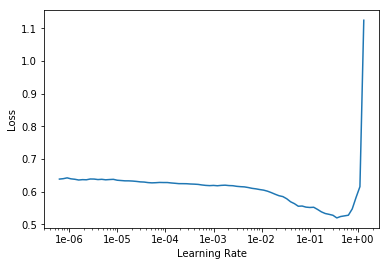

In [27]:
# Show the loss at different learning rates
learn.lr_find()
learn.recorder.plot()

The loss has a pretty steep decline at about 3e-02. Let's fit the model and display the learning rate and momentum.

epoch,train_loss,valid_loss,accuracy
1,0.320867,0.336328,0.867361


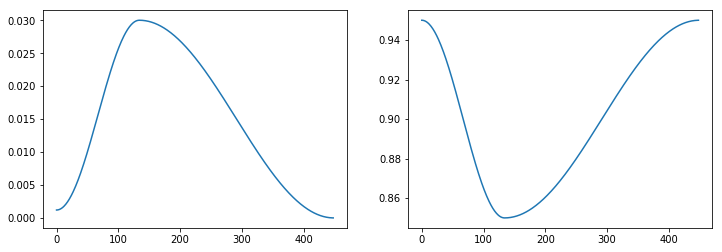

In [28]:
learn.fit_one_cycle(1, max_lr=3e-2, wd=0.2)
learn.save('stage-1')
learn.recorder.plot_lr(show_moms=True)

In [29]:
learn.fit_one_cycle(1, max_lr=3e-2, wd=0.2)
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.331376,0.338992,0.866667


In [30]:
learn.fit_one_cycle(2, max_lr=3e-2, wd=0.2)
learn.save('stage_3')

epoch,train_loss,valid_loss,accuracy
1,0.344953,0.344839,0.867361
2,0.326159,0.337427,0.867500


Our losses are lowest with this neural network after just one epoch.

In [31]:
learn.load('stage-1');

In [32]:
valid_preds, valid_y = learn.get_preds(ds_type=DatasetType.Valid)
valid_preds, valid_y = [x[1] for x in to_np(valid_preds)], to_np(valid_y)
print("Positive Prediction:", np.mean(valid_preds)*100, '%')

Positive Prediction: 11.968711763620377 %


It also is much more willing to make positive predictions, and it is in line with the validation set class percentages. Let's double-check by plotting those predictions against actual class balance through a calibration plot.

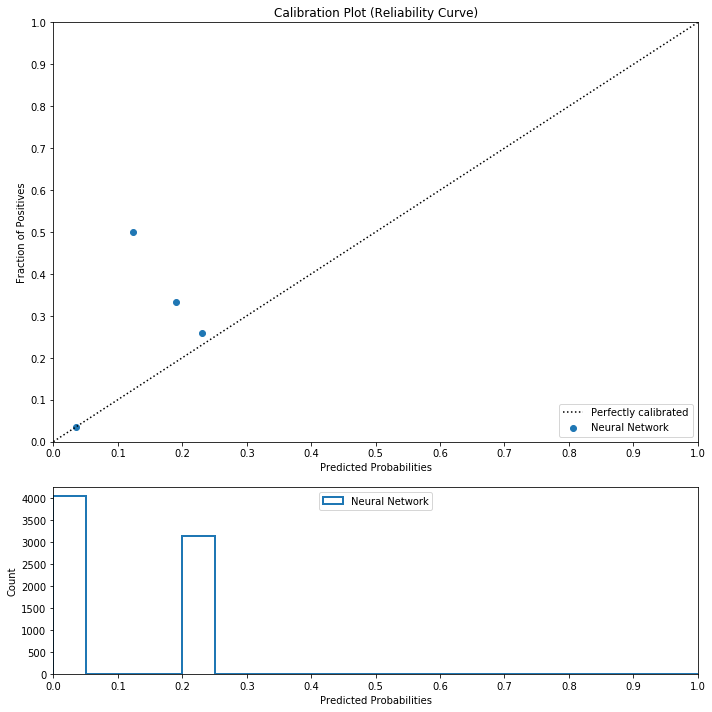

In [33]:
# Plot calibration curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

from sklearn.calibration import calibration_curve

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Compare true values to predictions
fraction_of_positives, mean_predicted_value = calibration_curve(valid_y, valid_preds, n_bins=20)

# Calibration Curve
ax1.scatter(mean_predicted_value, fraction_of_positives, label='Neural Network')
ax1.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax1.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax1.set_xlabel("Predicted Probabilities")
ax1.set_ylabel("Fraction of Positives")
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.legend(loc="lower right")
ax1.set_title('Calibration Plot (Reliability Curve)')

# Histogram
ax2.hist(valid_preds, range=(0, 1), bins=20, label='Neural Network', histtype="step", lw=2)
ax2.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax2.set_xlabel("Predicted Probabilities")
ax2.set_xlim([0, 1])
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=1)

plt.tight_layout()
plt.show()

Let's apply our predictions to the validation set to get a sense of how to interpret the model. *The model predicts the probability of which meal a user will pick.* To know how many meals to order, we would have to sum up the amount of meals actually ordered versus the sum of the probability predictions for those meals. We'll start by plotting the errors on these sums.

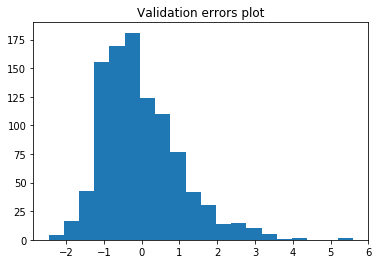

In [30]:
valid['prediction'] = valid_preds
y = list(valid.groupby('meal_id')['meal_ordered_yesterday'].sum())
yhat = list(valid.groupby('meal_id')['prediction'].sum())
errors = [a-b for a, b in zip(y, yhat)]
plt.hist(errors, bins=20)
plt.title('Validation errors plot')
plt.show()

The most likely outcome is that it gets it about right. There is some significant right-skew, indicating that the model can under-predict some circumstances. The errors seem *normal enough* to do some standard statistical work and generate prediction intervals.

In [31]:
# Get the standard deviation
sumerrs = np.sum([(a-b)**2 for a, b in zip(y, yhat)])
stdev = np.sqrt(sumerrs/(len(y)))

# Do 90% (95), 95% (97.5), and 99% (99.5) prediction invtervals and see how often predictions fall within upper bound
interval_z = 1.645 * stdev
upper_z = [x + interval_z for x in yhat]
within_interval_z = [np.ceil(b) >= a for a, b in zip(y, upper_z)]

interval_z2 = 1.96 * stdev
upper_z2 = [x + interval_z2 for x in yhat]
within_interval_z2 = [np.ceil(b) >= a for a, b in zip(y, upper_z2)]

interval_z3 = 2.576 * stdev
upper_z3 = [x + interval_z3 for x in yhat]
within_interval_z3 = [np.ceil(b) >= a for a, b in zip(y, upper_z3)]

pct_within_z = np.round(sum(within_interval_z)*100/len(within_interval_z), 2)
pct_within_z2 = np.round(sum(within_interval_z2)*100/len(within_interval_z2), 2)
pct_within_z3 = np.round(sum(within_interval_z3)*100/len(within_interval_z3), 2)

print("On the validation set...")
print("Within interval +1 stdev {}% of the time (theoretical 95.0%)".format(pct_within_z))
print("Within interval +2 stdev {}% of the time (theoretical 97.5%)".format(pct_within_z2))
print("Within interval +3 stdev {}% of the time (theoretical 99.5%)".format(pct_within_z3))

On the validation set...
Within interval +1 stdev 98.0% of the time (theoretical 95.0%)
Within interval +2 stdev 98.4% of the time (theoretical 97.5%)
Within interval +3 stdev 99.6% of the time (theoretical 99.5%)


Can we use this prediction interval formula on the on the meals sent set? Are the test and validation sets similar?

In [32]:
mean_users_sent = np.mean(test_df.groupby('meal_id')['user_id'].count())
mean_users_seen = np.mean(valid.groupby('meal_id')['user_id'].count())

avg_user_diff = (mean_users_sent - mean_users_seen)
expected_order_diff = avg_user_diff*0.14
print('The average sent meal should expect', np.round(expected_order_diff, 2), 
      'more orders compared to the validation set for a total of', np.round(mean_users_sent*0.14, 2), "orders.")

The average sent meal should expect 6.89 more orders compared to the validation set for a total of 7.89 orders.


In [33]:
print("On the meals to be sent set...")
meals_sent['prediction'] = test_preds
print("    The average predicted likelihood of a user selecting a meal was", np.round(meals_sent['prediction'].mean(), 
                                                                               3)*100, '%.')
meals_to_send = meals_sent.groupby('meal_id')['prediction'].sum().reset_index()
print("    The recommender suggest sending an average of", np.round(meals_to_send['prediction'].mean(), 2), 
      "orders.")

On the meals to be sent set...
    The average predicted likelihood of a user selecting a meal was 4.7 %.
    The recommender suggest sending an average of 2.64 orders.


The recommender is clearly treating the test set differently compared to the validation set. Why could this be occurring?

Possibilities include:

* There are many more users on the validation set for whom we do not have past data.
* We used ordered yesterday as our target in training, presumably the end of the cycle. This contained more data on what had been ordered over the course of the cycle. The meals sent is the beginning of the cycle and features unseen meals. 

Let's look more closely at the meals to be sent predictions

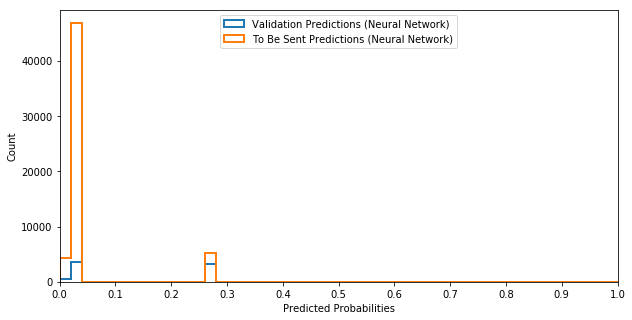

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(valid_preds, range=(0, 1), bins=50, label='Validation Predictions (Neural Network)', histtype="step", lw=2)
ax.hist(test_preds, range=(0, 1), bins=50, label='To Be Sent Predictions (Neural Network)', histtype="step", lw=2)
ax.legend(loc="upper center", ncol=1)
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Predicted Probabilities")
ax.set_xlim([0, 1])
ax.set_ylabel("Count")
ax.legend(loc="upper center", ncol=1)
plt.show()

Notice how much more even things were between the two bumps in the validation predictions! The differences in the seen data versus the unseen data are clearly being reflected in the model's predictions.

To rectify this, we should adjust for the of possibility a portion of the prediction probabilities around 0.0 belong in the ~0.25 bin. We'll apply the adjustment to all low predictions.

In [35]:
# Calculate the difference between frequency of high predictions
percent_high_valid = len(valid['prediction'].loc[valid['prediction'] >= 0.2])/len(valid)
percent_high_test = len(meals_sent['prediction'].loc[meals_sent['prediction'] >= 0.2])/len(meals_sent)
percent_high_diff = percent_high_valid - percent_high_test

# Calculate the ratio of the the middle high and middle low predictions
mid_high = 1 - percent_high_valid/2
mid_high_quantile = valid['prediction'].quantile(mid_high)
mid_low = (1 - percent_high_valid)/2
mid_low_quantile = valid['prediction'].quantile(mid_low)
ratio_pred = mid_high_quantile/mid_low_quantile

# Raise according to the difference in high predictions by the ratio of the differences
avg_raise = percent_high_diff*ratio_pred

meals_sent['new_prediction'] = meals_sent['prediction']
meals_sent['new_prediction'][meals_sent['prediction'] <= 0.1] = meals_sent['prediction']*(1+avg_raise)
print("Increasing low new predictions by", np.round(avg_raise, 2)*100, "%")
print("New average probability:", np.round(meals_sent['new_prediction'].mean(), 4)*100, "%")
meals_to_send = meals_sent.groupby('meal_id')['new_prediction'].sum().reset_index()
mean_meals_to_send = meals_to_send['new_prediction'].mean()
print("The recommender now suggests sending an average of", np.round(mean_meals_to_send, 4), 
      "orders.")

Increasing low new predictions by 366.0 %
New average probability: 12.790000000000001 %
The recommender now suggests sending an average of 7.2101 orders.


/Users/matthewignal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


This is roughly in line with what we would expect.

Finally, to calculate prediction intervals, we should make an adjustment by looking at how the error changed as the prediction changed.

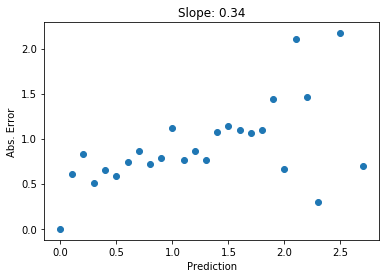

In [36]:
zip_errors = [(np.round(x, 1), np.round(y, 1)) for x, y in zip(yhat, np.abs(errors))]
zip_errors_df = pd.DataFrame(zip_errors, columns=['prediction', 'errors'])
mean_errors = zip_errors_df.groupby('prediction').mean().reset_index()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat, np.abs(errors))
plt.scatter(mean_errors['prediction'], mean_errors['errors'])
plt.title('Slope: {}'.format(np.round(slope, 2)))
plt.xlabel('Prediction')
plt.ylabel('Abs. Error')
plt.show()

Our absolute error increases by the slope for each 1 prediction. We'll adjust the prediction intervals by taking the product of the slope and the difference of the meal predictions between the two sets.

In [37]:
multiplier = (np.mean(mean_meals_to_send)-np.mean(yhat))*slope
print('Interval multiplier:', np.round(multiplier, 2))

# Calculate new intervals
meals_to_send['95th Percentile Interval'] = np.ceil(meals_to_send['new_prediction'] + interval_z*multiplier)
meals_to_send['97th Percentile Interval'] = np.ceil(meals_to_send['new_prediction'] + interval_z2*multiplier)
meals_to_send['99th Percentile Interval'] = np.ceil(meals_to_send['new_prediction'] + interval_z3*multiplier)

Interval multiplier: 2.15


In [38]:
print(meals_to_send.head())
meals_to_send.to_csv('output.csv')

   meal_id  new_prediction  95th Percentile Interval  \
0     1000        7.023204                      11.0   
1     1001        8.196882                      12.0   
2     1002        7.990185                      12.0   
3     1003        8.920914                      13.0   
4     1004        3.919874                       8.0   

   97th Percentile Interval  99th Percentile Interval  
0                      12.0                      13.0  
1                      13.0                      15.0  
2                      13.0                      14.0  
3                      14.0                      15.0  
4                       9.0                      10.0  


## Final Thoughts

If this were real data in a real-world scenario, I would not recommend implementing this algorithm as-is. The task of needing to engineer the target, combined with the difference between the data to be used for training versus how it would be applied makes this a poor choice for determining how many meals should be recommended.

A better process would be to have a time-series of records of each day across many subscription cycles. That would provide a rich historical dataset from which we could more confidently apply an algorithm's predictions knowing the application on new data would be similar to the data found in the training and validation sets.

Thanks for following along!